In [1]:
import numpy as np
import matplotlib.pyplot as plt
import random
import os
import PIL
import tensorflow as tf
from tensorflow import keras

from tensorflow.keras.utils import to_categorical                        # tools for creating one-hot encoding
from tensorflow.keras.models import Sequential                       # Type of model we wish to use
from tensorflow.keras.layers import Dense, Dropout, Activation  # Types of layers we wish to use

from skimage.transform import resize                      # Used to scale/resize image arrays

from sklearn.metrics import confusion_matrix              # Used to quickly make confusion matrix

In [13]:
### Settings

# Location of dataset
DATASET_PATH = "images"

# Desired resolution of images
TARGET_WIDTH = 28
TARGET_HEIGHT = 28

# Invert image (dark backgrounds can sometimes improve accuracy)
INVERT = False

# Set aside 20% for validation and 20% for test
VAL_RATIO = 0.2
TEST_RATIO = 0.2

# You are welcome to change the seed to try a different validation set split
random.seed(42)

In [14]:
### Load images as Numpy arrays

# We want to record the labels and assign a ground truth label as a number to each sample
labels = []
y_all = []    # Lowercase 'y' - 1D vector of the ground labels (n)
X_all = []    # Uppercase 'X' - 3D array of all image samples (n x width x height)

In [15]:
# Find the directories in the dataset folder (skip the Jupyter Notebook checkpoints hidden folder)
for label in os.listdir(DATASET_PATH):
  class_dir = os.path.join(DATASET_PATH, label)
  if os.path.isdir(class_dir) and label != ".ipynb_checkpoints":

    # Add the name of the folder to our labels list
    labels.append(label)

    # Go through each image in the folder
    for i, file in enumerate(os.listdir(class_dir)):

      # Skip the Jupyter Notebook checkpoints folder that sometimes gets added
      if file != ".ipynb_checkpoints":

        # Open image and convert to grayscale
        file_path = os.path.join(class_dir, file)
        img = PIL.Image.open(file_path).convert('L')

        # Convert the image to a Numpy array, optionally invern, and append to X
        img_array = np.asarray(img)
        if INVERT:
          img_array = 255 - img_array
        X_all.append(img_array)

        # Add label to the y array
        y_all.append(label)

    # Show how many images we loaded
    print("Added", str(i + 1), "images from", label)
    
# Calculate total number of samples
num_samples = len(X_all)

# Sort the labels list by alphabetical order
labels = sorted(labels)

# Print out labels and number of samples
print(labels)
print("Number of samples:", num_samples)

Added 50 images from background
Added 50 images from capacitor
Added 50 images from diode
Added 50 images from led
Added 50 images from resistor
['background', 'capacitor', 'diode', 'led', 'resistor']
Number of samples: 250


In [16]:
### Convert labels to numbers

# Show the labels before the conversion
print("Before:", y_all)

# Convert each label to its index in the labels
y_out = []
for i, label in enumerate(y_all):
  y_out.append(labels.index(label))
y_all = y_out

# Show the labels after the conversion
print("After:", y_all)

Before: ['background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'background', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capacitor', 'capa

In [17]:
### Shuffle samples and labels together, divide into test, validation, and training sets

# Shuffle samples and associated labels together
X_y = list(zip(X_all, y_all))
random.shuffle(X_y)
X_all, y_all = zip(*X_y)

# Calculate number of validation and test samples to put aside (round down)
num_samples_test = int(TEST_RATIO * num_samples)
num_samples_val = int(VAL_RATIO * num_samples)

# The first `num_samples_test` samples of the shuffled list becomes the test set
X_test = X_all[:num_samples_test]
y_test = y_all[:num_samples_test]

# The next `num_samples_val` samples of the shuffled list becomes the validation set
X_val = X_all[num_samples_test:(num_samples_test + num_samples_val)]
y_val = y_all[num_samples_test:(num_samples_test + num_samples_val)]

# The remaining samples become the training set
X_train = X_all[(num_samples_test + num_samples_val):]
y_train = y_all[(num_samples_test + num_samples_val):]

# Remember the number of samples in the test set
num_samples_train = len(X_train)

# Print out the number of test, validation, and training samples
print("Number of test samples:", num_samples_test)
print("Number of validation samples:", num_samples_val)
print("Number of training samples:", num_samples_train)

Number of test samples: 50
Number of validation samples: 50
Number of training samples: 150


Label: 2 (diode)
[[147 147 149 ... 149 149 149]
 [147 147 149 ... 149 149 149]
 [147 147 149 ... 149 149 149]
 ...
 [139 139 139 ... 155 155 155]
 [139 139 139 ... 149 155 155]
 [139 139 139 ... 149 149 155]]


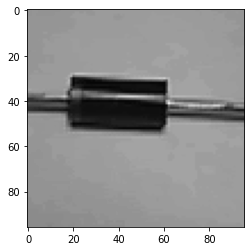

In [18]:
### View one of the training samples

# Chose which sample you want to view
idx = 0

# Print out label (numbe and string) and part of the array
print("Label: " + str(y_train[idx]) + " (" + labels[y_train[idx]] + ")")
print(X_train[idx])

# Display image from array
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=255)

In [19]:
### Function to resize list of images
def resize_images(images, width, height, anti_aliasing=True):
  """
  Prove a list of Numpy arrays (in images parameter) to have them all resized to desired height and
  width. Returns the list of newly resized image arrays.

  NOTE: skimage resize returns *normalized* image arrays (values between 0..1)
  """
  X_out = []
  for i, img in enumerate(images):
    X_out.append(resize(img, (height, width), anti_aliasing=anti_aliasing))
  return X_out

In [20]:
### Scale/crop images

# Resize (scale) all images in the training set
X_train = resize_images(X_train, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the validation set
X_val = resize_images(X_val, TARGET_WIDTH, TARGET_HEIGHT)

# Resize (scale) all images in the test set
X_test = resize_images(X_test, TARGET_WIDTH, TARGET_HEIGHT)

Label: 2 (diode)
First row: [[0.57647059 0.57647059 0.57647059 0.57647059 0.58011204 0.58209284
  0.59607843 0.59233693 0.59159664 0.6        0.6        0.59629852
  0.6        0.60084034 0.60392157 0.6047619  0.60784314 0.60784314
  0.6047619  0.6047619  0.60392157 0.60392157 0.6        0.59977991
  0.5929972  0.58829532 0.58401361 0.58039216]]


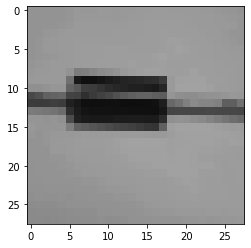

In [21]:
### View training sample again (after they all have been scaled)

# Chose which sample you want to view
idx = 0

# Print out label (numbe and string) and part of the array
print("Label: " + str(y_train[idx]) + " (" + labels[y_train[idx]] + ")")
print("First row:", X_train[idx][:1,:])

# Display image from array (note that images have been normalized)
plt.imshow(X_train[idx], cmap='gray', vmin=0, vmax=1)

In [22]:
### Convert list of samples and labels into Numpy arrays

# Training set
X_train = np.asarray(X_train)
y_train = np.asarray(y_train)

# Validation set
X_val = np.asarray(X_val)
y_val = np.asarray(y_val)

# Test set
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

# Print out the new Numpy array shapes (always a good idea to check the shapes!)
print("Training X:", X_train.shape)
print("Training y:", y_train.shape)
print("Validation X:", X_val.shape)
print("Validation y:", y_val.shape)
print("Test X:", X_test.shape)
print("Test y:", y_test.shape)

Training X: (150, 28, 28)
Training y: (150,)
Validation X: (50, 28, 28)
Validation y: (50,)
Test X: (50, 28, 28)
Test y: (50,)


In [23]:
### Flatten each image to a 1D vector (DNN requires 1D input)

# Compute length of 1D array that we will flatten each image to
len_vector = TARGET_WIDTH * TARGET_WIDTH

# Flatten matricies to vectors
X_train = X_train.reshape(num_samples_train, len_vector)
X_val = X_val.reshape(num_samples_val, len_vector)
X_test = X_test.reshape(num_samples_test, len_vector)

# Determine the input shape for our Keras model (must be tuple)
input_shape = (X_train.shape[1],)

# Print out shapes
print("X train:", X_train.shape)
print("y train:", y_train.shape)
print("X val:", X_val.shape)
print("y val:", y_val.shape)
print("X test:", X_test.shape)
print("y test:", y_test.shape)
print("Input tensor shape:", input_shape)

X train: (150, 784)
y train: (150,)
X val: (50, 784)
y val: (50,)
X test: (50, 784)
y test: (50,)
Input tensor shape: (784,)


In [26]:
### Convert labels (integers) to one-hot encoding

# Get number of classes
num_classes = len(labels)

# Use Keras's utils to create one-hot encoding (note the capital 'Y' - 2D array)

Y_train = tf.keras.utils.to_categorical(y_train, num_classes)
Y_val = tf.keras.utils.to_categorical(y_val, num_classes)
Y_test = tf.keras.utils.to_categorical(y_test, num_classes)

# Print out shapes (capital 'Y' is our one-hot matrix!)
print("Y train:", Y_train.shape)
print("Y val:", Y_val.shape)
print("Y test:", Y_test.shape)

# Print out a few examples from training set
for i in range(10):
  print("Label: " + str(y_train[i]) + " | One-hot:", Y_train[i])

Y train: (150, 5)
Y val: (50, 5)
Y test: (50, 5)
Label: 2 | One-hot: [0. 0. 1. 0. 0.]
Label: 2 | One-hot: [0. 0. 1. 0. 0.]
Label: 4 | One-hot: [0. 0. 0. 0. 1.]
Label: 4 | One-hot: [0. 0. 0. 0. 1.]
Label: 4 | One-hot: [0. 0. 0. 0. 1.]
Label: 0 | One-hot: [1. 0. 0. 0. 0.]
Label: 2 | One-hot: [0. 0. 1. 0. 0.]
Label: 3 | One-hot: [0. 0. 0. 1. 0.]
Label: 2 | One-hot: [0. 0. 1. 0. 0.]
Label: 0 | One-hot: [1. 0. 0. 0. 0.]


In [27]:
### Construct Keras model

# A sequential model is a linear stack of layers
model = Sequential()

# First layer: fully-connected with relu activation
model.add(Dense(64, input_shape=input_shape))
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Second layer: fully-connected with relu activation
model.add(Dense(64))   # Input shape is determined automatically from previous layer
model.add(Activation('relu'))
model.add(Dropout(0.25))

# Third layer: 10 nodes, one for each class, and softmax activation
model.add(Dense(num_classes))
model.add(Activation('softmax'))

# Configure the model's training settings
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['acc'])

# Print out model summary
print(model.summary())

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 64)                50240     
_________________________________________________________________
activation (Activation)      (None, 64)                0         
_________________________________________________________________
dropout (Dropout)            (None, 64)                0         
_________________________________________________________________
dense_1 (Dense)              (None, 64)                4160      
_________________________________________________________________
activation_1 (Activation)    (None, 64)                0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 64)                0         
_________________________________________________________________
dense_2 (Dense)              (None, 5)                 3

In [28]:
### Train the model... this is where your hyperparameter tuning happens and
# you can make changes
history = model.fit(X_train, 
                    Y_train, 
                    batch_size=32, 
                    epochs=200, 
                    verbose=1,
                    validation_data=(X_val, Y_val))

Epoch 1/200
5/5 [==============================] - 0s 47ms/step - loss: 1.8039 - acc: 0.1933 - val_loss: 1.6465 - val_acc: 0.1400
Epoch 2/200
5/5 [==============================] - 0s 6ms/step - loss: 1.6217 - acc: 0.2600 - val_loss: 1.5436 - val_acc: 0.2000
Epoch 3/200
5/5 [==============================] - 0s 15ms/step - loss: 1.5715 - acc: 0.2667 - val_loss: 1.4631 - val_acc: 0.4800
Epoch 4/200
5/5 [==============================] - 0s 14ms/step - loss: 1.5203 - acc: 0.3400 - val_loss: 1.4326 - val_acc: 0.5800
Epoch 5/200
5/5 [==============================] - 0s 6ms/step - loss: 1.4736 - acc: 0.3600 - val_loss: 1.4318 - val_acc: 0.6200
Epoch 6/200
5/5 [==============================] - 0s 8ms/step - loss: 1.4398 - acc: 0.4467 - val_loss: 1.4116 - val_acc: 0.4600
Epoch 7/200
5/5 [==============================] - 0s 4ms/step - loss: 1.4081 - acc: 0.4733 - val_loss: 1.3349 - val_acc: 0.8200
Epoch 8/200
5/5 [==============================] - 0s 5ms/step - loss: 1.3392 - acc: 0.5133 - 

5/5 [==============================] - 0s 4ms/step - loss: 0.2744 - acc: 0.9200 - val_loss: 0.3945 - val_acc: 0.8800
Epoch 65/200
5/5 [==============================] - 0s 5ms/step - loss: 0.3068 - acc: 0.8867 - val_loss: 0.3838 - val_acc: 0.9000
Epoch 66/200
5/5 [==============================] - 0s 5ms/step - loss: 0.2674 - acc: 0.9333 - val_loss: 0.3747 - val_acc: 0.8600
Epoch 67/200
5/5 [==============================] - 0s 4ms/step - loss: 0.2662 - acc: 0.9133 - val_loss: 0.3856 - val_acc: 0.8800
Epoch 68/200
5/5 [==============================] - 0s 21ms/step - loss: 0.2495 - acc: 0.9000 - val_loss: 0.3666 - val_acc: 0.8800
Epoch 69/200
5/5 [==============================] - 0s 5ms/step - loss: 0.2846 - acc: 0.8800 - val_loss: 0.4252 - val_acc: 0.9000
Epoch 70/200
5/5 [==============================] - 0s 10ms/step - loss: 0.2664 - acc: 0.9267 - val_loss: 0.3728 - val_acc: 0.9000
Epoch 71/200
5/5 [==============================] - 0s 4ms/step - loss: 0.2136 - acc: 0.9400 - val_lo

Epoch 127/200
5/5 [==============================] - 0s 5ms/step - loss: 0.1385 - acc: 0.9533 - val_loss: 0.4073 - val_acc: 0.8800
Epoch 128/200
5/5 [==============================] - 0s 5ms/step - loss: 0.1044 - acc: 0.9667 - val_loss: 0.3737 - val_acc: 0.9000
Epoch 129/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1236 - acc: 0.9533 - val_loss: 0.4743 - val_acc: 0.9000
Epoch 130/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1121 - acc: 0.9600 - val_loss: 0.3978 - val_acc: 0.8800
Epoch 131/200
5/5 [==============================] - 0s 5ms/step - loss: 0.1078 - acc: 0.9600 - val_loss: 0.3881 - val_acc: 0.8800
Epoch 132/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1098 - acc: 0.9600 - val_loss: 0.5232 - val_acc: 0.9000
Epoch 133/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1048 - acc: 0.9600 - val_loss: 0.4364 - val_acc: 0.9000
Epoch 134/200
5/5 [==============================] - 0s 5ms/step - loss: 0.1395 - a

5/5 [==============================] - 0s 4ms/step - loss: 0.0739 - acc: 0.9667 - val_loss: 0.4615 - val_acc: 0.8800
Epoch 190/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0981 - acc: 0.9733 - val_loss: 0.4459 - val_acc: 0.8800
Epoch 191/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0738 - acc: 0.9600 - val_loss: 0.4975 - val_acc: 0.9000
Epoch 192/200
5/5 [==============================] - 0s 4ms/step - loss: 0.1253 - acc: 0.9533 - val_loss: 0.4440 - val_acc: 0.8800
Epoch 193/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0636 - acc: 0.9867 - val_loss: 0.4636 - val_acc: 0.8800
Epoch 194/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0517 - acc: 0.9800 - val_loss: 0.4858 - val_acc: 0.9000
Epoch 195/200
5/5 [==============================] - 0s 4ms/step - loss: 0.0382 - acc: 0.9933 - val_loss: 0.4437 - val_acc: 0.8800
Epoch 196/200
5/5 [==============================] - 0s 5ms/step - loss: 0.0318 - acc: 1.0000 - v

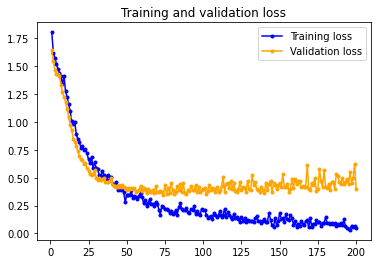

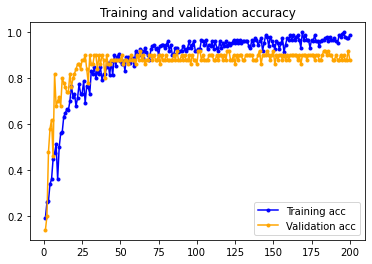

In [29]:
### Plot training and validation accuracy and loss over time

# Extract accuracy and loss values (in list form) from the history
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

# Create a list of epoch numbers
epochs = range(1, len(acc) + 1)

# Plot training and validation loss values over time
plt.figure()
plt.plot(epochs, loss, color='blue', marker='.', label='Training loss')
plt.plot(epochs, val_loss, color='orange', marker='.', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

# Plot training and validation accuracies over time
plt.figure()
plt.plot(epochs, acc, color='blue', marker='.', label='Training acc')
plt.plot(epochs, val_acc, color='orange', marker='.', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()
plt.show()

In [35]:
### Try predicting label with one validation sample (inference)

# Change this to try a different sample from the test set. You may get misses shown.
idx = 10

# Make sample 2D array instead of 1D vector (this is what the Keras model expects as input)
x = np.expand_dims(X_val[idx], 0)

# Make prediction using trained model
y_pred = model.predict(x)

# Find index of highest score in output
predicted_label = np.argmax(y_pred)
actual_label = np.argmax(Y_val[idx])

# Display model output, predicted label, actual label
print("Model output:", y_pred)
print("Predicted label:", predicted_label, "-", labels[predicted_label])
print("Actual label:", actual_label, "-", labels[actual_label])

Model output: [[0.00408255 0.29950142 0.01376214 0.46004593 0.22260803]]
Predicted label: 3 - led
Actual label: 1 - capacitor


In [36]:
### Create confusion matrix from validation set

# Find predictions from all validation samples
Y_pred = model.predict(X_val)
print("Validation output shape:", Y_pred.shape)

# Convert actual and predicted validation one-hot encoding to numerical labels
y_val = np.argmax(Y_val, axis=1)
y_pred = np.argmax(Y_pred, axis=1)

# Print some values from actual and predicted validation sets (first 50 samples)
print("Actual validation labels:\t", y_val[:50])
print("Predicted validation labels:\t", y_pred[:50])

# Compute confusion matrix (note: we need to transpose SKLearn matrix to make it match Edge Impulse)
cm = confusion_matrix(y_val, y_pred)
cm = np.transpose(cm)

# Print confusion matrix
print()
print(" ---> Predicted labels")
print("|")
print("v Actual labels")
print("\t\t\t" + ' '.join("{!s:6}".format('(' + str(i) + ')') for i in range(num_classes)))
for row in range(num_classes):
  print("{:>12} ({}):  [{}]".format(labels[row], row, ' '.join("{:6}".format(i) for i in cm[row])))

Validation output shape: (50, 5)
Actual validation labels:	 [2 2 3 2 0 1 4 1 4 0 1 2 2 2 4 0 4 0 4 0 3 3 4 2 3 4 0 4 3 1 1 0 3 0 4 4 1
 0 0 3 3 4 0 2 3 1 0 2 4 4]
Predicted validation labels:	 [2 2 3 2 0 1 4 1 4 0 3 2 2 4 4 0 2 0 4 0 3 3 2 2 3 4 0 1 4 1 1 0 3 0 4 4 1
 0 0 3 3 4 0 2 3 1 0 2 4 4]

 ---> Predicted labels
|
v Actual labels
			(0)    (1)    (2)    (3)    (4)   
  background (0):  [    12      0      0      0      0]
   capacitor (1):  [     0      6      0      0      1]
       diode (2):  [     0      0      8      0      2]
         led (3):  [     0      1      0      8      0]
    resistor (4):  [     0      0      1      1     10]


In [37]:
### Evaluate model on validation set
score = model.evaluate(X_val, Y_val)
print("Validation loss:", score[0])
print("Validation accuracy:", score[1])

2/2 [==============================] - 0s 2ms/step - loss: 0.3959 - acc: 0.8800
Validation loss: 0.39591601490974426
Validation accuracy: 0.8799999952316284


In [38]:
### Evaluate model on entire test set
score = model.evaluate(X_test, Y_test)
print("Test loss:", score[0])
print("Test accuracy:", score[1])

2/2 [==============================] - 0s 1000us/step - loss: 0.1023 - acc: 0.9200
Test loss: 0.10231848806142807
Test accuracy: 0.9200000166893005
